# Customer Lifetime Value Prediction
### Using Bayesian Till You Die package + Beta-Geometric NBD Part 1
### Basic CLV prediction (CDNow dataset)


## Step 1: Install/Load Libraries and Set environment variables

In [58]:
#Use R kernel to run this notebook.  Program is written in R language

install.packages('devtools')
library('devtools')
install_github("llooker/advanced_analytics_accelerator/lookr/")
install.packages("readxl")
install.packages("ggplot2")
install.packages("dplyr")
install.packages("BTYDplus")
install.packages("bigrquery")
install.packages("googleCloudStorageR")

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Skipping install of 'lookr' from a github remote, the SHA1 (409dc8a0) has not changed since last install.
  Use `force = TRUE` to force installation

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



In [59]:
library(lookr)
library(ggplot2)
library(readxl)
library(dplyr)
library(BTYDplus)
library(bigrquery)
library(googleCloudStorageR)

In [61]:
## Load core functions

#authenticate into bq

provideBQAuthentication <- function(json_path="../service/auth.json",projectid=Sys.getenv("GC_BQ_PROJECTID"),
                                    datasetid=Sys.getenv("GC_BQ_DATASETID"),conn="bq_conn") 
{
  bq_auth(path = json_path)
  bq_auth(use_oob = TRUE)
  df <-  dbConnect(bigquery(),
                        project = projectid,
                        dataset = datasetid,
                        use_legacy_sql = FALSE
  )
  #browser()
  assign(conn, df, envir=.GlobalEnv)
  assign("projectid",projectid, envir=.GlobalEnv)
  assign("datasetid",datasetid, envir=.GlobalEnv)
}


## Step 2: Download Looker Action Hub data saved in GCS bucket

In [62]:
# Original idea was to use lookR package to download look, but migrating to grabbing GCS object data = get_look(look_id = 325, limit = -1)

data <- gcs_get_object("looker.csv")

#renaming fields
colnames(data) <- c('cust', 'date', 'orders', 'sales')


── Column specification ────────────────────────────────────────────────────────
cols(
  `Advanced Analytics Accelerator ID` = col_double(),
  `Advanced Analytics Accelerator Transaction Date` = col_date(format = ""),
  `Advanced Analytics Accelerator Total Cds Purchased` = col_double(),
  `Advanced Analytics Accelerator Gross Sales` = col_double()
)




In [63]:
str(data)

spec_tbl_df [67,591 × 4] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ cust  : num [1:67591] 1 2 3 3 3 3 3 3 4 4 ...
 $ date  : Date[1:67591], format: "1997-01-01" "1997-01-12" ...
 $ orders: num [1:67591] 1 6 1 2 2 2 4 5 1 2 ...
 $ sales : num [1:67591] 11.8 89 17 19.5 20.8 ...
 - attr(*, "spec")=
  .. cols(
  ..   `Advanced Analytics Accelerator ID` = col_double(),
  ..   `Advanced Analytics Accelerator Transaction Date` = col_date(format = ""),
  ..   `Advanced Analytics Accelerator Total Cds Purchased` = col_double(),
  ..   `Advanced Analytics Accelerator Gross Sales` = col_double()
  .. )


## Step 3: Aggregate into customer-level parameters

Compute the average order size for each customer using the total sales and the number of orders. Finally, set the prediction horizon (T.star) to one month (31 days) for everyone. If we want to predict future spend across a different length of time, we can just change T.star.

In [64]:
customer_rdf <- BTYDplus::elog2cbs(
data,
unit = 'days',
T.cal = max(data$date),
T.tot = max(data$date)
)
customer_rdf$sales_avg = customer_rdf$sales / (customer_rdf$x + 1)

bgnbd_rdf <- customer_rdf
bgnbd_rdf$T.star <- 31 #prediction period is over the next 31 (T.star value) days (unit value)

Next, use a Beta-Geometric NBD (Negative Binomial Distribution) to predict CLV

In [65]:
#use a Beta-Geometric NBD (Negative Binomial Distribution) to predict CLV

params_bgnbd <- BTYD::bgnbd.EstimateParameters(bgnbd_rdf) # BG/NBD
bgnbd_rdf$predicted_bgnbd <- BTYD::bgnbd.ConditionalExpectedTransactions(
params = params_bgnbd,
T.star = bgnbd_rdf$T.star,
x = bgnbd_rdf$x,
t.x = bgnbd_rdf$t.x,
T.cal= bgnbd_rdf$T.cal
)

## Step 4: Calculate Predicted CLV

In [66]:
bgnbd_rdf$predicted_clv <- bgnbd_rdf$sales_avg * bgnbd_rdf$predicted_bgnbd


## Visualize Results

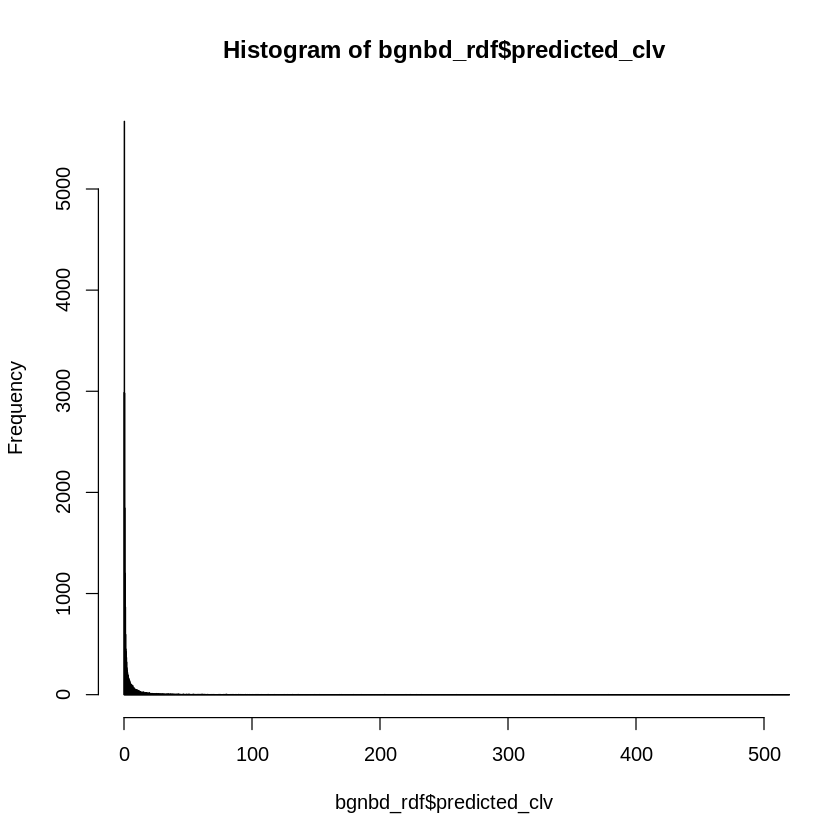

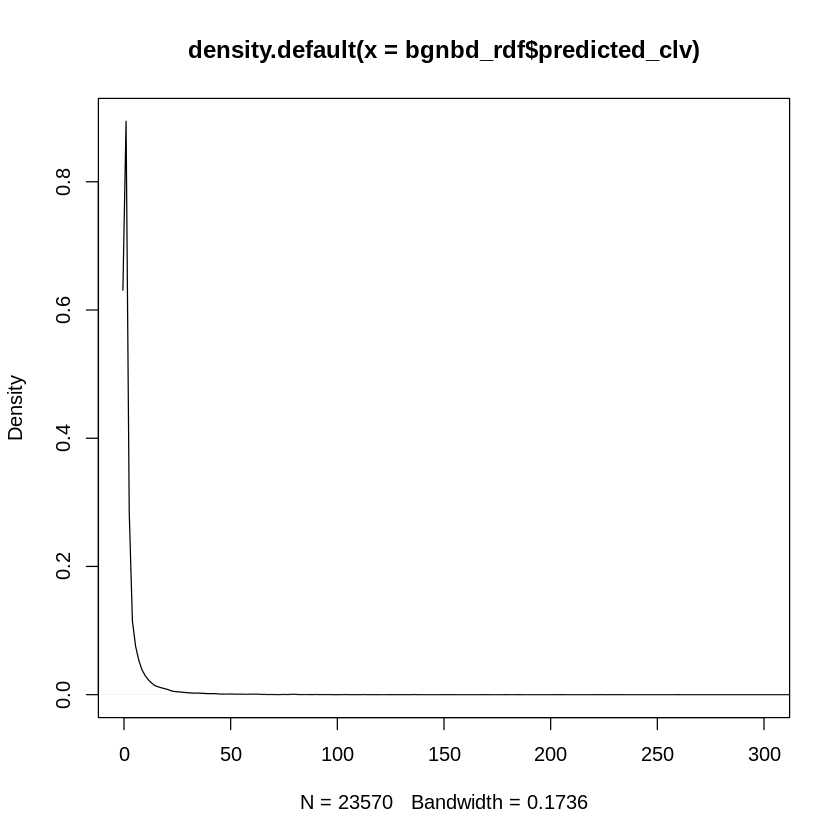

In [67]:
hist(bgnbd_rdf$predicted_clv, xlim=c(0,500), breaks=3000)
plot(density(bgnbd_rdf$predicted_clv), xlim=c(0,300))

## Step 5: Ship back to BigQuery

In [68]:
#update column names for proper BQ formatting
colnames(bgnbd_rdf) <- c('cust', 'x', 'tx', 'litt','sales','salesx','first','Tcal','sales_avg','Tstar','predicted_fut_transactions','predicted_clv')

In [69]:
#auth into BQ
provideBQAuthentication()

In [71]:
#push to BQ
createBigQueryTable('cdnow_clvpred_new',bgnbd_rdf)

Auto-refreshing stale OAuth token.

Complete

Input:  4.48 MB

Output: 2.26 MB

